Report containing scripts for the StylED project.

Author: Elian Strozyk

# (Down)loading packages

In [1]:
!pip install numpy
!pip install pandas
!pip install Bio
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
from Bio import SeqIO, Entrez
from Bio.Blast import NCBIWWW, NCBIXML

Entrez.email = "elian.strozyk@etu.umontpellier.fr"

# Extracting sequences

Sequences are retrieved using their NCBI ID and the Entrez and SeqIO modules from Biopython.

In [3]:
# All stylins identified and their NCBI ID
# 01, 02, 03, 04, 04bis, 05
NCBI_Gene_ID = ["NM_001162314.1",
                "NM_001162671.2",
                "NM_001161959.2",
                "NM_001172260.1",
                "NM_001172268.2",
                "NM_001163252.1"
               ]

NCBI_protein_ID = ["NP_001155786.1",
                   "NP_001156143.1",
                   "NP_001155431.1",
                   "NP_001165731.1",
                   "NP_001165739.1",
                   "NP_001156724.1"
                  ]

## Retrieving DNA

In [4]:
dna_search_results = Entrez.efetch("Nucleotide",
                                   id = ",".join(NCBI_Gene_ID),
                                   rettype = "fasta"
                                  )
dna_records = SeqIO.parse(dna_search_results, "fasta")
#write a fasta file with stylin's sequences
SeqIO.write(dna_records, "./stylin_dna_sequence.fasta", "fasta")

6

## Retrieving proteins

In [5]:
protein_search_results = Entrez.efetch("Protein",
                                       id = ",".join(NCBI_protein_ID),
                                       rettype = "fasta"
                                      )
protein_records = SeqIO.parse(protein_search_results, "fasta")
# write a fasta file with stylin's sequences
SeqIO.write(protein_records, "./stylin_protein_sequence.fasta", "fasta")

6

# Working with proteins and *Aphididae*

Here, we mostly work with proteins because scoring matrices (for aligning) are more modulable than those for nucleic sequences due to the alphabet size.

Stylin orthologs are retrieved using different databases, then they are aligned and plotted into a phylogenetic tree.

Three databases were used:
* NCBI (BLASTp and BLASTx: available with Biopython)
* BIPAA (BLAST online: doesn't seem to be available with command lines)
* MetaPhOrs (not available with command lines)

BIPAA is a database that focuses on arthropods, it contains aphid genomes not referenced in NCBI.

MetaPhOrs is a database that aims to find orthologs and paralogs in species with a reference genome. It combines multiple repositories. In our case, this database does not provide enough results with the default parameters. Moreover, it lacks many filtering options.

## NCBI

NCBI's BLAST can be run with Biopython's qblast() function.

The qblast() function doesn't seem to work with several sequences:
* With one sequence as input, it will return several sequences
* With several sequences as input, it will return only one sequence

As such, a way to avoid this problem is to run as many BLASTs as stylin sequences. This method is not very optimised, I might have to check other Python libraries.

BLAST's parameters were changed to match the online ones in order to retrieve as many sequences as possible. Parameters were also aligned with those of AphidBase's BLAST.

In [6]:
hit_ids = [] # stores all returned protein's IDs 
for stylin in NCBI_protein_ID :
    result_handle = NCBIWWW.qblast(program = "blastp",
                                   database = "nr",
                                   sequence = stylin,
                                   entrez_query = "Aphididae[Organism]",
                                   expect = 0.01,
                                   gapcosts = "11 1",
                                   hitlist_size = 250,
                                   word_size = 3,
                                   matrix_name = "BLOSUM62"
                                  )
    blast_records = NCBIXML.parse(result_handle)
    for blast_record in blast_records :
        for alignment in blast_record.alignments :
            if alignment.hit_id not in hit_ids :
                hit_ids.append(alignment.hit_id) # append all HSP IDs
    with open(f"{stylin}_protein_blast.xml", "w") as fd :
        fd.write(result_handle.read()) # write a file with all BLAST results appended. Doesn't work, file's empty
    result_handle.close()
    blast_records.close()

A few stats and saving protein IDs and a multifasta containing all sequences.

In [8]:
print("Number of returned sequences:", len(hit_ids))

# storing all sequences as text and fasta files
with open("blast_protein_ids.txt", "w") as ft :
    ft.write("\n".join(hit_ids))

protein_search_results = Entrez.efetch("Protein",
                                       id = ",".join(hit_ids),
                                       rettype = "fasta"
                                      )
protein_records = SeqIO.parse(protein_search_results, "fasta")
SeqIO.write(protein_records, "./blast_protein_sequences.fasta", "fasta")

Number of returned sequences: 338


338

Plotting the results to make it eye-catching.

In [9]:
# Creation of a dictionary to stock all species and their sequence count
import re

dictionary = {}
with open("blast_protein_sequences.fasta", "r") as file :
    for line in file :
        for key in re.findall("\[(.*)\]", line) :
            if key not in dictionary :
                dictionary[key] = 1
            else :
                dictionary[key] += 1

Text(0, 0.5, 'Count')

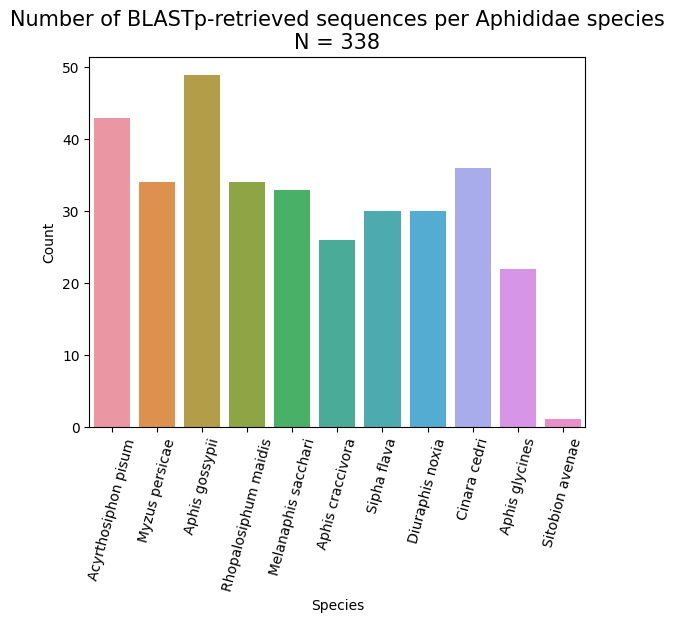

In [10]:
# plotting the resulting dictionary
import seaborn as sns

plot = sns.barplot(x = list(dictionary.keys()),
                   y = list(dictionary.values())
                  )
plot.set_xticklabels(plot.get_xticklabels(), rotation = 75)
plot.set_title("Number of BLASTp-retrieved sequences per Aphididae species\nN = 338", size = 15)
plot.set_xlabel("Species")
plot.set_ylabel("Count")

## MetaPhOrs

The orthologs resulting from querying this database are obtained for any species and there is no option to filter taxa. Plus, you can only query one sequence at a time. As such, sequences belonging to the *Aphididae* clade were filtered by hands because they were not numerous. However, this will be complicated with clades deeper in the phylogenetic tree.

Missing stylin sequences among the six already known were appended.

Text(0, 0.5, 'Count')

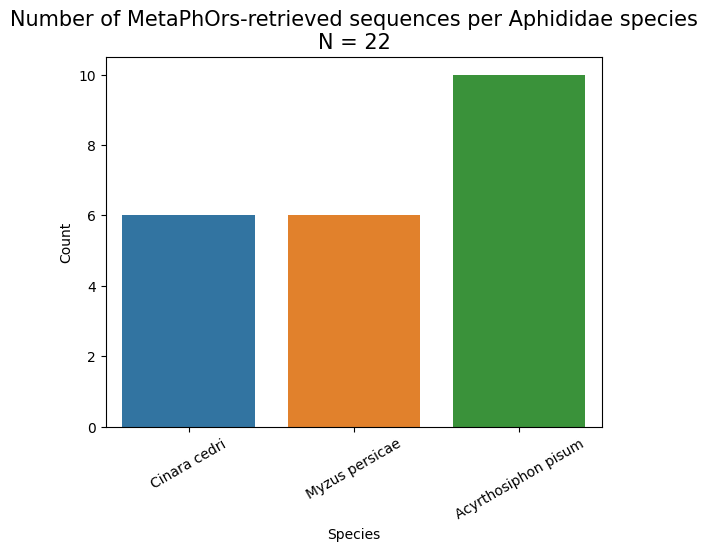

In [11]:
speciesCounter = {}
with open("../metaphors/stylin_orthologs_aphididae.metaphors.fasta") as fd :
    for line in fd :
        for key in re.findall("\[(.*)\]", line) :
            if key not in speciesCounter :
                speciesCounter[key] = 1
            else :
                speciesCounter[key] += 1
plot = sns.barplot(x = list(speciesCounter.keys()),
                   y = list(speciesCounter.values())
                  )
plot.set_xticklabels(plot.get_xticklabels(), rotation = 30)
plot.set_title("Number of MetaPhOrs-retrieved sequences per Aphididae species\nN = 22", size = 15)
plot.set_xlabel("Species")
plot.set_ylabel("Count")

## BIPAA's AphidBase

AphidBase contains 11 aphid genomes. It can run BLAST, but it can only apply to a single at a time.
* *Acyrtosiphon pisum*
* *Myzus persicae*
* *Aphis gossypii*
* *Rhopalosiphum maidis*
* *Diuraphis noxia*
* *Aphis glycines*
* *Daktulosphaira vitifoliae*
* *Eriosoma lanigerum*
* *Myzus cerasi*
* *Pentalonia nigronervosa*
* *Rhopalosiphum padi*

Parameters:
* **program = blastp**
* search_type = normal
* **sequence**
* databank_type = public
* databank = ???
* **expect = 0.01**
* word_size = 3
* **max_target_sequences = 250**
* matrix = BLOSUM62
* gap_costs = 11 1
* composition_adjustments = conditional_compositional_score

## Alignment

# Summary

* Extraction of stylin's DNA and protein sequences
* Protein orthologs were retrieved from three databases: NCBI, MetaPhOrs, BIPAA's AphidBase

# Improvements

* Run a single BLAST with all sequences instead of 6 BLASTs with one sequence.
* For MetaPhOrs: write a script to remove from a multifasta redundant sequences and filter out species not belonging to a clade. However, need to find a way to filter by species, but cannot find a newick format tree for aphids.